In [1]:
import sys
import matplotlib.lines as mlines
import os.path
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns
from scipy.stats.stats import pearsonr 
from sklearn.decomposition import PCA
cmap = plt.cm.get_cmap('Blues')

%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set_style('white')
sns.set_context('notebook', font_scale=1.7, rc={'lines.linewidth': 1.3})


# ------------------------- auxiliary functions ----------------------------------

# ------------------------ calculate fold change ---------------------------------
def FC(X, y, absolute=False):
    if set(y) != {0,1}:
        print 'Only two classes accepted: y=0 and y=1'
        return 0
    if len(y) != np.shape(X)[1]:
        print 'check the length of y'
        return 0
    fc = np.mean(X[:,y==0], axis=1) - np.mean(X[:,y==1], axis=1)
    if absolute:
        return np.abs(fc)
    return fc
# -------------------------------------------------------------------------------


# ------- Suvrel method. For details please see (Boareto et al, 2015) -----------
def suvrel(X, y, gamma=None, p=None, print_gamma=False):
    if set(y) != {0,1}:
        print 'Only two classes accepted: y=0 and y=1'
        return 0
    
    if len(y) != np.shape(X)[1]:
        print 'check the length of y'
        return 0
    
    if gamma==None:
        if p==None:
            print 'Define either gamma or a minimum p-value'
            return 0
        else:
            t = 2.0*special.erfcinv(p)
            gamma = 1.0/(t**2 + 2.0)
    elif gamma>0.5:
        print 'gamma>0.5, are you sure?'
        
    sum_var = np.var(X[:,y==0], axis=1) + np.var(X[:,y==1], axis=1)
    w = gamma*FC(X, y)**2 - (1.0 - 2.0*gamma)*sum_var
    w[w<0] = 0.0
    
    if print_gamma:
        print 'Suvrel analysis: gamma = ',gamma
        
    return [w/np.sqrt(np.sum(w**2)), 2*w]
# -------------------------------------------------------------------------------


# --------------- estimate the correlation between two samples -----------------
def pcorr(x,y, log_scale=False):
    if log_scale:
        x = np.log2(x)
        y = np.log2(y)
    [corr,p] = pearsonr(x, y)
    a,b   = np.polyfit(x, y, 1) 
    return [corr, p, a, b]
# -------------------------------------------------------------------------------


# ----------------- plot a PCA representation of the data -----------------------
def dimensional_reduction(D, pc=[0,1], c='g', clabel=None, cbar=True, clim=None, xticks=[], yticks=[], cticks=None, x_fit=None, 
                          cmap='Blues', fs=[9,5], ms=200, marker=None, label=None, ax=None, return_fit=False, xlim=None, ylim=None):
    if ax==None:
        f = plt.subplots(1, 1, figsize=(fs[0], fs[1]), sharex=True, sharey=True)
        ax = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)
    if x_fit==None:
        x_fit = PCA(n_components=3).fit(D.T)
    x = x_fit.transform(D.T)

    im = plt.scatter(x[:,pc[0]], x[:,pc[1]], c=c, cmap=cmap, marker='o', s=ms, alpha=0.9)
    if label!=None:
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.8))
    if cbar:
        cbar = plt.colorbar(im, orientation='vertical')
        if cticks!=None:
            cbar.ax.set_yticks(set(c))
            cbar.ax.set_yticklabels(cticks)
        if clabel!=None:
            if clim!=None:
                plt.clim([clim[0], clim[1]])
            else:
                plt.clim([np.min(c), np.max(c)])
            cbar.set_label(clabel)
    if xlim!=None:
        plt.xlim(xlim)
    if ylim!=None:
        plt.ylim(ylim)
    if xticks!=None:
        plt.xticks(xticks)
    if yticks!=None:
        plt.yticks(yticks)
    ax.autoscale_view()
    if return_fit:
        return x_fit
# -------------------------------------------------------------------------------

### Data processing:

#### Raw data (.fastq files) were mapped using Bowtie2 algorithm. 
See shell script: bowtie2_processing.sh


#### Gene counts were generated from mapped data using HTSeq algorithm.
See shell script: htseq_processing.sh


#### For each .fastq file a .count were generated. See /counts folder

In [2]:
# Reading data form .counts files

path_counts = './counts/'
lists = 'list_counts.txt'
df_names  = []
col_names = []
for l in pd.read_csv(lists, header=None, sep='\n').values:
    if os.path.isfile(path_counts+l[0]): 
        col_names += [l[0]]
        df_names  += [pd.read_csv(path_counts+l[0], header=None, names=['gene_name', 'counts'], 
                      index_col=0, sep='\t')]

D = {}
D['raw_data'] = pd.concat(df_names, axis=1)
D['raw_data'].columns = col_names
        
l_info = ['__no_feature','__ambiguous','__too_low_aQual','__not_aligned','__alignment_not_unique'] 
D['info']     = D['raw_data'].loc[l_info]
D['raw_data'] = D['raw_data'].drop(l_info)

# ------------------------------- renaming the columns ------------------------------------
# rep1 and rep2 are technical replicates from different libraries
# _1 and _2 are technical replicates from the same library
col_names = ['WT1_rep1_1', 'WT1_rep1_2', 'WT2_rep1_1', 'WT2_rep1_2', 'WT3_rep1_1', 'WT3_rep1_2',
             'KO1_rep1_1', 'KO1_rep1_2', 'KO2_rep1_1', 'KO2_rep1_2', 'KO3_rep1_1', 'KO3_rep1_2',
             'WT1_rep2_1', 'WT1_rep2_2', 'WT2_rep2_1', 'WT2_rep2_2', 'WT3_rep2_1', 'WT3_rep2_2',
             'KO1_rep2_1', 'KO1_rep2_2', 'KO2_rep2_1', 'KO2_rep2_2', 'KO3_rep2_1', 'KO3_rep2_2']
D['raw_data'].columns = col_names
D['info'].columns = col_names

In [3]:
# dividing the data into two technical replicates
D['rep1'] = D['raw_data'][D['raw_data'].columns[ 0:12]]
D['rep2'] = D['raw_data'][D['raw_data'].columns[12:24]]

columns = ['WT1','WT2','WT3','KO1','KO2','KO3']
index   = D['raw_data'].index
D['sum_1']   = pd.DataFrame(columns=columns, index=index) # replicate from library 1
D['sum_2']   = pd.DataFrame(columns=columns, index=index) # replicate from library 2
D['sum'  ]   = pd.DataFrame(columns=columns, index=index) # sum of the counts in both replicates
for k in columns:
    D['sum_1'][k] = (D['rep1'][k+'_rep1_1'] + D['rep1'][k+'_rep1_2']) # adding replicates from the same library 1
    D['sum_2'][k] = (D['rep2'][k+'_rep2_1'] + D['rep2'][k+'_rep2_2']) # adding replicates from the same library 2
    D['sum'][k] = (D['sum_1'][k] + D['sum_2'][k])
    

# ------------------- Normalization (counts per million) ------------------------------------
for k in ['sum_1', 'sum_2', 'sum']:
    D[k] = np.log2( (D[k]*1.0e+6)/np.sum(D[k].values, axis=0) + 1.0)

# defining the variable y that distiguishes WT (y=0) from KO (y=1) samples.
y = np.array([0,0,0,1,1,1])

### Checking for technical variance

/home/boareto/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


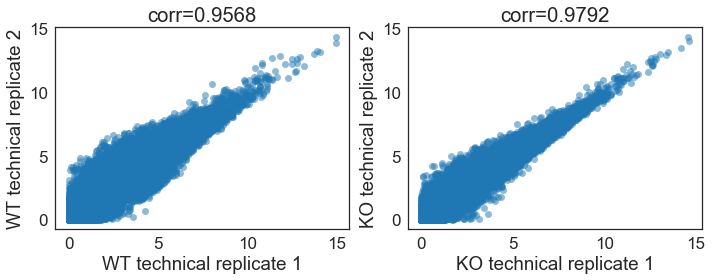

In [4]:
f = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
ax = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
wt_1 = np.mean(D['sum_1'].values[:,y==0], axis=1)
wt_2 = np.mean(D['sum_2'].values[:,y==0], axis=1)
plt.plot(wt_1, wt_2, 'o', alpha=0.5)
plt.title('corr='+str(np.round(pcorr(wt_1, wt_2)[0], 4)))
plt.xlabel('WT technical replicate 1')
plt.ylabel('WT technical replicate 2')

ax = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)
ko_1 = np.mean(D['sum_1'].values[:,y==1], axis=1)
ko_2 = np.mean(D['sum_2'].values[:,y==1], axis=1)
plt.plot(ko_1, ko_2, 'o', alpha=0.5)
plt.title('corr='+str(np.round(pcorr(ko_1, ko_2)[0], 4)))
plt.xlabel('KO technical replicate 1')
plt.ylabel('KO technical replicate 2')
plt.tight_layout()

### Checking the biological variance

In [5]:
f = plt.subplots(2, 3, figsize=(15, 8), tight_layout=True)

for i in range(3):
    for j in range(3):
        if j>i:
            ax = plt.subplot2grid((2, 3), (0, i+j-1), colspan=1, rowspan=1)
            wt_1 = D['sum_1'].values[:,i]
            wt_2 = D['sum_1'].values[:,j]
            plt.plot(wt_1, wt_2, 'o', alpha=0.5)
            plt.title('corr='+str(np.round(pcorr(wt_1, wt_2)[0], 4)))
            plt.xlabel('WT biological replicate '+str(i+1))
            plt.ylabel('WT biological replicate '+str(j+1))
            ax = plt.subplot2grid((2, 3), (1, i+j-1), colspan=1, rowspan=1)
            ko_1 = D['sum_1'].values[:,3+i]
            ko_2 = D['sum_1'].values[:,3+j]
            plt.plot(ko_1, ko_2, 'o', alpha=0.5)
            plt.title('corr='+str(np.round(pcorr(ko_1, ko_2)[0], 4)))
            plt.xlabel('KO biological replicate '+str(i+1))
            plt.ylabel('KO biological replicate '+str(j+1))

plt.tight_layout()

#### We observed a large difference in the biological variance between different biological samples. We found that the origin of such large variability is the amount of cells selected in order to do the sequencying. Samples with different number of cells have high differences, and such differences increase with the differences in the amount of cells selected. 

#### This means that statistical methods are not suitable for comparing those samples, since the biological replicates have different number of selected cells, which lead to a large techincal noise that could be interpreted as biological noise. For this reason, we chose to compare the samples via a supervised method (Suvrel). For details about the method, please check the reference (Boareto et al, 2015).  

In [6]:
# applying the method Suvrel in order to select the most significant genes. 
X = D['sum'].values
n, m = X.shape
s = suvrel(X, y, gamma=1.0/3.0)


# Plotting the PCA representation of the data before and after Suvrel analysis
f = plt.subplots(1, 2, figsize=(12, 4.5), tight_layout=True)
ax = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
c = [cmap(0.4), cmap(0.4),cmap(0.4),cmap(1.0),cmap(1.0),cmap(1.0)]
x_fit = dimensional_reduction(X, c=c, xticks=[], yticks=[], ax=ax, cbar=False, return_fit=True, ms=350)
plt.xlabel('Principal component 1 ('+str(100*round(x_fit.explained_variance_ratio_[0], 3))+'%)')
plt.ylabel('Principal component 2 ('+str(100*round(x_fit.explained_variance_ratio_[1], 3))+'%)')
plt.title('PCA analysis.')
leg0 = mlines.Line2D([], [], c=cmap(0.4), marker='o', linewidth=0, 
                          markersize=15, label='WT')
leg1 = mlines.Line2D([], [], c=cmap(1.0), marker='o', linewidth=0,
                          markersize=15, label='KO')
plt.legend(handles=[leg0, leg1])

ax = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)
x_fit = dimensional_reduction(X*np.dot(s[0].reshape(n,1),np.ones((1,m))), 
                      c=c, xticks=[], yticks=[], ax=ax, cbar=False, return_fit=True, ms=350)
plt.xlabel('Principal component 1 ('+str(100*round(x_fit.explained_variance_ratio_[0], 3))+'%)')
plt.ylabel('Principal component 2 ('+str(100*round(x_fit.explained_variance_ratio_[1], 3))+'%)')
plt.title('PCA analysis after Suvrel method.')
plt.tight_layout()

In [7]:
# selecting the top genes and writing into a file
n_topgenes = 1000

orig_stdout = sys.stdout
f = open('Suvrelv2_top1000_withFC.txt', 'w')
sys.stdout = f
fc = FC(X,y)
top_fc = fc[np.argsort(-s[0])[:n_topgenes]]
l_topgenes = D['sum'].index[np.argsort(-s[0])[:n_topgenes]]
for g in range(n_topgenes):
    print l_topgenes[g], '\t', -top_fc[g]
sys.stdout = orig_stdout
f.close()

# printing the amount of genes with positive and negative fold change
print np.sum(top_fc>0), np.sum(top_fc<0)

# comparing the suvrel score with the fold change
plt.plot(np.abs(fc[np.argsort(-s[0])[:1000]]), 'o')
plt.xlabel('Top 100 genes selected by suvrel')
plt.ylabel('Fold change')

161 839


Text(0,0.5,u'Fold change')

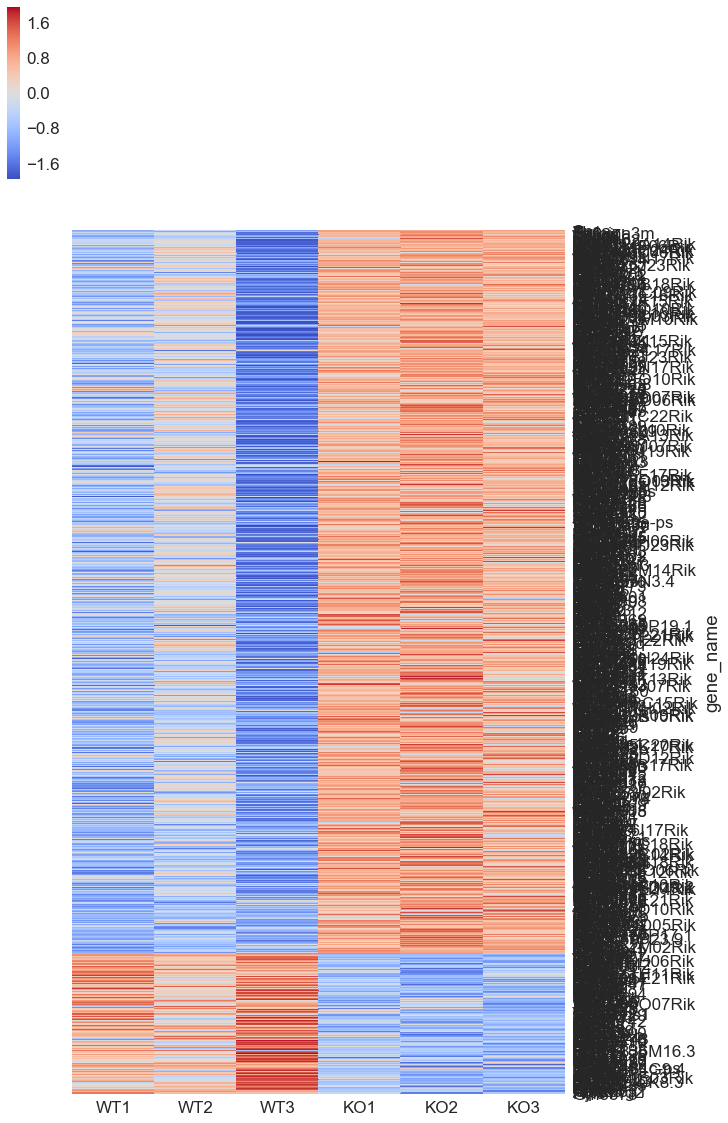

In [8]:
d_pd = pd.DataFrame(index=l_topgenes, columns=['foldchange'])
d_pd['foldchange'] = top_fc

yticks = np.array(d_pd.index)
g = sns.clustermap(D['sum'].loc[d_pd.sort_values('foldchange').index], yticklabels=yticks, cmap='coolwarm',z_score=0,
                   col_cluster=False, row_cluster=False, figsize=(10,20))

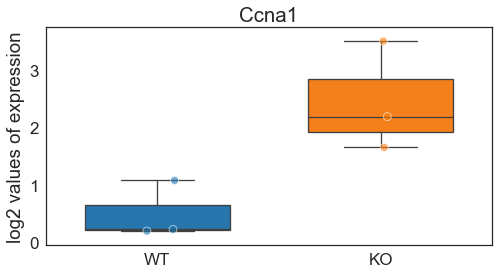

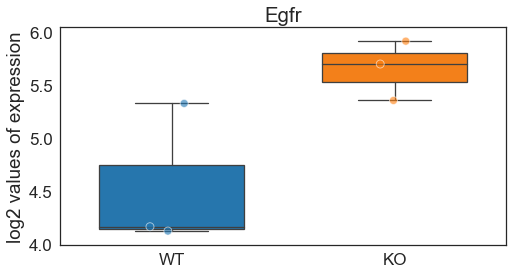

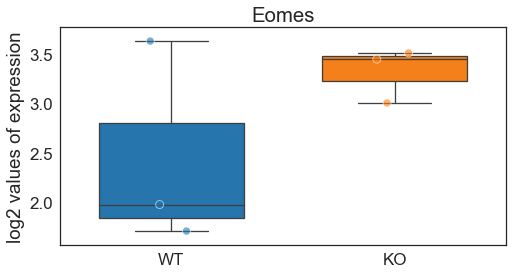

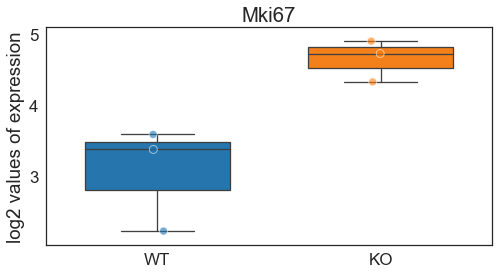

In [9]:
l_g = ['Id4', 'Ccna1', 'Ccne1', 'Egfr', 'Eomes', 'Hopx', 'Mki67'] 

for g in l_g:
    plt.figure(figsize=(8,4))
    data = [np.mean(D['sum'].loc[[g]].values[:,y==0], axis=0), 
            np.mean(D['sum'].loc[[g]].values[:,y==1], axis=0),
           ]
    sns.boxplot(  data=data, saturation=0.9, width=0.65, fliersize=0)
    sns.stripplot(data=data, jitter=True,  size=8, linewidth=0.9, edgecolor='w', marker='o', alpha=0.6)
    plt.title(g)    
    plt.xticks([0, 1],['WT','KO'])
    plt.ylabel('log2 values of expression')

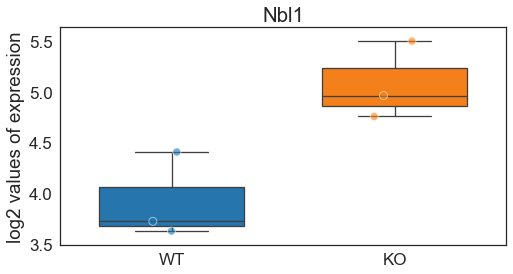

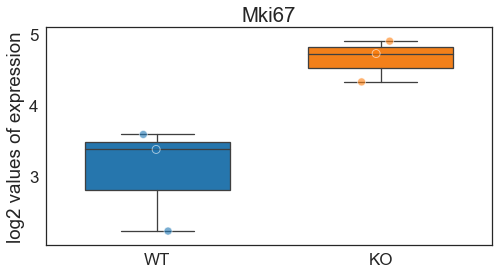

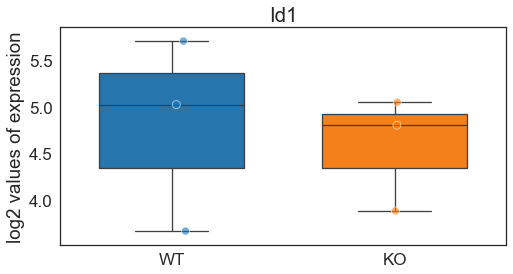

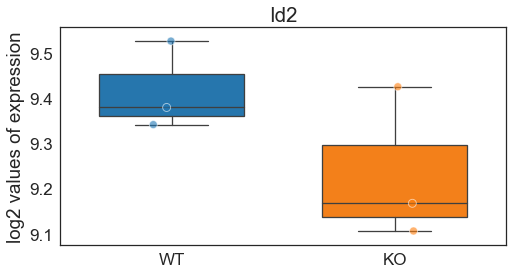

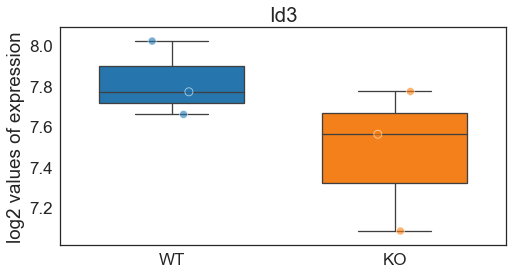

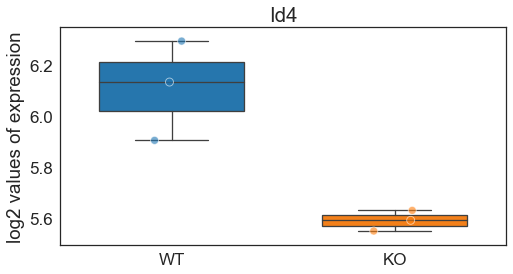

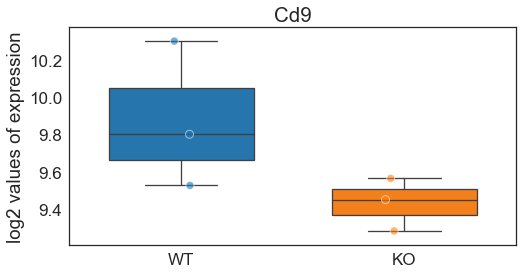

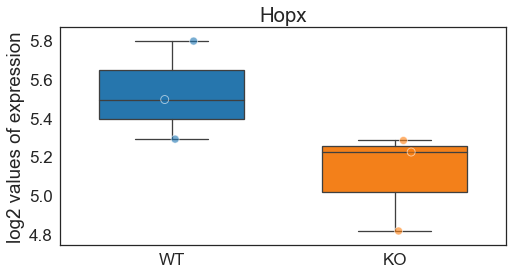

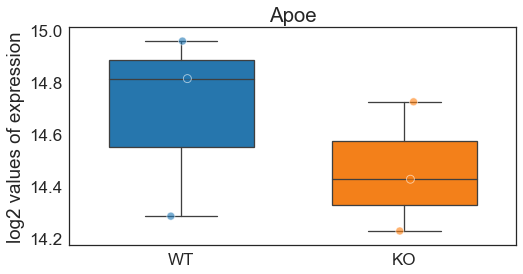

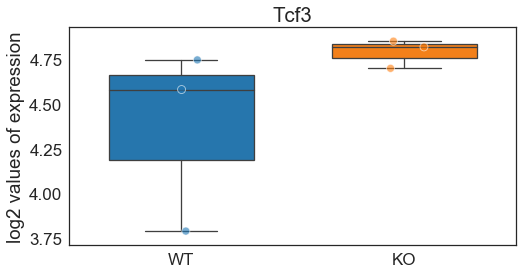

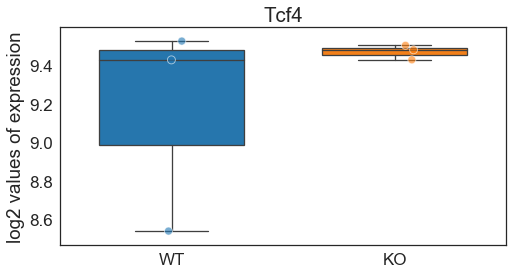

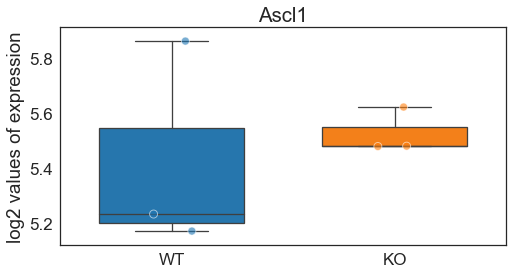

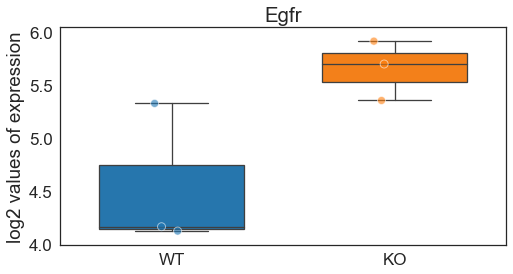

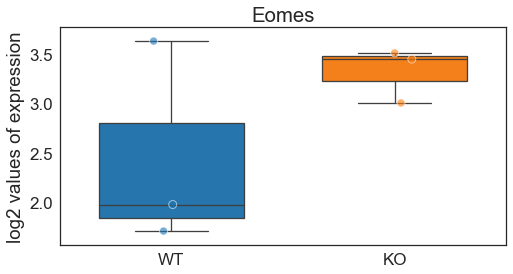

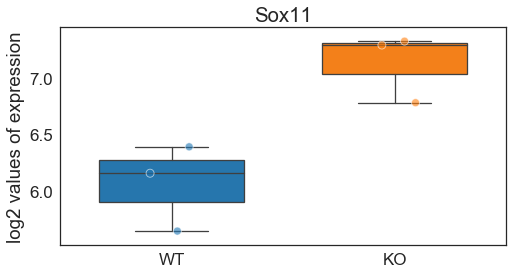

In [11]:
l_g = ['Chrdl1', 'Nbl1','Mki67', 'Id1', 'Id2', 'Id3', 'Id4', 'Cd9', 'Hopx', 'Apoe', 'Tcf3', 'Tcf4',
       'Ascl1', 'Egfr', 'Eomes', 'Sox11'] 

for g in l_g:
    plt.figure(figsize=(8,4))
    data = [np.mean(D['sum'].loc[[g]].values[:,y==0], axis=0), 
            np.mean(D['sum'].loc[[g]].values[:,y==1], axis=0),
           ]
    sns.boxplot(  data=data, saturation=0.9, width=0.65, fliersize=0)
    sns.stripplot(data=data, jitter=True,  size=8, linewidth=0.9, edgecolor='w', marker='o', alpha=0.6)
    plt.title(g)    
    plt.xticks([0, 1],['WT','KO'])
    plt.ylabel('log2 values of expression')